In [1]:
%matplotlib inline
import numpy as np
from pycocotools.coco import COCO
import skimage.io as io
import matplotlib.pyplot as plt
import theano.tensor as T
import theano
import lasagne
import lasagne.nonlinearities as nonlin
import pylab
import pickle
import re
import os
import imageio
import time
from IPython.display import display, clear_output
import PIL

from net.vgg16 import make_network_from_file
from net.process import preprocess, resize_img

--- Logging error ---
Traceback (most recent call last):
  File "E:\WinPython-64bit-3.4.4.1\python-3.4.4.amd64\lib\logging\__init__.py", line 978, in emit
    msg = self.format(record)
  File "E:\WinPython-64bit-3.4.4.1\python-3.4.4.amd64\lib\logging\__init__.py", line 828, in format
    return fmt.format(record)
  File "E:\WinPython-64bit-3.4.4.1\python-3.4.4.amd64\lib\logging\__init__.py", line 573, in format
    record.exc_text = self.formatException(record.exc_info)
  File "E:\WinPython-64bit-3.4.4.1\python-3.4.4.amd64\lib\logging\__init__.py", line 523, in formatException
    traceback.print_exception(ei[0], ei[1], tb, None, sio)
  File "E:\WinPython-64bit-3.4.4.1\python-3.4.4.amd64\lib\traceback.py", line 169, in print_exception
    for line in _format_exception_iter(etype, value, tb, limit, chain):
  File "E:\WinPython-64bit-3.4.4.1\python-3.4.4.amd64\lib\traceback.py", line 146, in _format_exception_iter
    for value, tb in values:
  File "E:\WinPython-64bit-3.4.4.1\python-3.4

In [2]:
dataDir='annotations_trainval2017'
dataType='val2017'
annFile='{}/annotations/captions_{}.json'.format(dataDir, dataType)

coco=COCO(annFile)

loading annotations into memory...
Done (t=0.17s)
creating index...
index created!


# img2vec

In [3]:
from net.imgs import *
      
# %time imgs_process('annotations_trainval2017/img') # Wall time: 4h 43min 38s

In [4]:
imgs = imgs_load(dataDir)
display(len(imgs))

4991

In [5]:
temp = pickle.load(open('annotations_trainval2017\data\\130.data', 'rb'))
temp = list(temp.items())
print('max =', np.max(temp[10][1][1]))
print('min =', np.min(temp[10][1][1]))

max = 7.29067086791
min = 0.0


# texts

In [6]:
from net.sents_process import *

# sents_process(dict_from_anns(coco.anns), 'annotations_trainval2017')

In [7]:
anno = sent_load(dataDir)

In [8]:
danno = {}
for id, v in anno:
    danno[id] = danno.get(id, []) + [v]

In [9]:
captions = [text[1]['caption'] for text in coco.anns.items()]
display(captions[:5])

['Two mean are playing tennis and both are wearing sunglasses.  ',
 'a couple of people that are playing in a field',
 'A purple and white bus in a parking lot.',
 'a tennis player swinging a racket at a ball',
 'a person attempting a jump with a skateboard']

# neural networks

In [10]:
from net.train import *

# CNN

Generate X, y

In [11]:
H = 300
W = 14

In [12]:
train_size = 23300

X, y = [], []
for id, data in imgs.items():
    while id[0] == '0':
        id = id[1:]
    try:
        for ls in danno[id]:
            vects = []
            for elem in ls:
                if not isinstance(elem, str):
                    vects.append(elem)
            vects = np.pad(vects, [(0, W), (0, 0)], mode='constant', constant_values=0)[:W].T
            X.append([vects])
            y.append(data[1])
    except:
        pass

print(len(X))

X_train, y_train, X_val, y_val = X[:train_size], y[:train_size], X[train_size:], y[train_size:]

23968


In [13]:
#with open('data.net', 'wb') as fl:
#    pickle.dump((X_train, y_train, X_val, y_val), fl)

# new version

In [14]:
def build_cnn(file_name=None):
    net = NeuralNet(must_have=[
            'input_shape', 
            'learning_rate', 
            'train_fun', 
            'loss_fun', 
            'loss_fun_det', 
            'predict_fun_det'])
    
    input_shape = [None, H, W]
    
    input_X = T.tensor3("input X", dtype='float32')
    target_y = T.matrix("target Y", dtype='float32')

    
    net['inp'] = lasagne.layers.InputLayer(input_shape, input_var=input_X)
    
    net['max'] = lasagne.layers.GlobalPoolLayer(net['inp'], pool_function=theano.tensor.max)
    net['min'] = lasagne.layers.GlobalPoolLayer(net['inp'], pool_function=theano.tensor.min)
    net['mean'] = lasagne.layers.GlobalPoolLayer(net['inp'], pool_function=theano.tensor.mean)
    
    net['con_2'] = lasagne.layers.Conv1DLayer(net['inp'], num_filters=64, filter_size=2,nonlinearity=None)
    net['con_3'] = lasagne.layers.Conv1DLayer(net['inp'], num_filters=64, filter_size=3,nonlinearity=None)
    net['con_4'] = lasagne.layers.Conv1DLayer(net['inp'], num_filters=64, filter_size=4,nonlinearity=None)
    
    net['gmax_2'] = lasagne.layers.GlobalPoolLayer(net['con_2'], pool_function=T.max)
    net['gmax_3'] = lasagne.layers.GlobalPoolLayer(net['con_3'], pool_function=T.max)
    net['gmax_4'] = lasagne.layers.GlobalPoolLayer(net['con_4'], pool_function=T.max)
    
    
    #x = T.tensor3("temp", dtype='float32')
    #axis = T.scalar(dtype='int32')
    #ex = T.exp(x)
    #boltzmann_max = theano.function([x, axis], theano.sum(x * ex, axis=axis) / theano.sum(ex, axis=axis), allow_input_downcast=True)
    boltzmann_max = lambda a, axis: T.sum(a * T.exp(a), axis=-1) / T.exp(a).sum(-1)
    
    net['gmax_2b'] = lasagne.layers.GlobalPoolLayer(net['con_2'], pool_function=boltzmann_max)
    net['gmax_3b'] = lasagne.layers.GlobalPoolLayer(net['con_3'], pool_function=boltzmann_max)
    net['gmax_4b'] = lasagne.layers.GlobalPoolLayer(net['con_4'], pool_function=boltzmann_max)
    
    net['merge'] = lasagne.layers.ConcatLayer((net['max'], net['min'], net['mean'], 
                                               net['gmax_2'], net['gmax_3'], net['gmax_4'],
                                               net['gmax_2b'], net['gmax_3b'], net['gmax_4b']))
    
    net['dens_1'] = lasagne.layers.DenseLayer(net['merge'], num_units=500, nonlinearity=nonlin.elu)
    net['batch_1'] =  lasagne.layers.batch_norm(net['dens_1'])
    net['drop_1'] = lasagne.layers.DropoutLayer(net['batch_1'], p=0.5)
    
    net['dens_2'] = lasagne.layers.DenseLayer(net['drop_1'], num_units=500, nonlinearity=nonlin.elu)
    net['batch_2'] =  lasagne.layers.batch_norm(net['dens_2'])
    net['drop_2'] = lasagne.layers.DropoutLayer(net['batch_2'], p=0.5)
    
    net['last'] = lasagne.layers.DenseLayer(net['drop_2'], num_units=4096)
    
    
    y_predicted = lasagne.layers.get_output(net['last'])
    y_predicted_det = lasagne.layers.get_output(net['last'], deterministic=True)

    all_weights = lasagne.layers.get_all_params(net['last'], trainable=True)
    
    learning_rate = theano.shared(lasagne.utils.floatX(0.001))
    loss = lasagne.objectives.squared_error(target_y, y_predicted).mean()
    loss_det = lasagne.objectives.squared_error(target_y, y_predicted_det).mean()
    
    # loss = loss + lasagne.regularization.regularize_layer_params(net['last'], lasagne.regularization.l2) * 0.01
    updates = lasagne.updates.adam(loss, all_weights, learning_rate=learning_rate)
    
    train_fun = theano.function([input_X, target_y], loss, updates=updates, allow_input_downcast=True)
    loss_fun = theano.function([input_X, target_y], loss, allow_input_downcast=True)
    loss_fun_det = theano.function([input_X, target_y], loss_det, allow_input_downcast=True)
    predict_fun_det = theano.function([input_X], y_predicted_det, allow_input_downcast=True)
    
    if file_name:
        load_net(net['last'], file_name, dataDir)
        
    def proc_vec(v):
        res = []
        for vv in v:
            res.append(vv[0])
        return res
    
    def proc_1(fun):
        def temp(v):
            v = proc_vec(v)
            return fun(v)
        return temp

    def proc_2(fun):
        def temp(v, u):
            v = proc_vec(v)
            return fun(v, u)

        return temp

    net.input_shape = input_shape
    net.learning_rate = learning_rate
    net.train_fun = proc_2(train_fun)
    net.loss_fun = proc_2(loss_fun)
    net.loss_fun_det = proc_2(loss_fun_det)
    net.predict_fun_det = proc_1(predict_fun_det)
    
    return net.check()

In [15]:
net = build_cnn()

1) поставить эксперемент с банч норм и без

2) рисовать сглаженные графики

3) потестить расположение дропаутов

4) 

In [16]:
for key,val in net.items():
    if isinstance(val,lasagne.layers.Layer):
        params = val.get_params()
        

        print (key, val.output_shape, [p.get_value().shape for p in params])

dens_1 (None, 500) [(1284, 500)]
dens_2 (None, 500) [(500, 500)]
max (None, 300) []
con_4 (None, 64, 11) [(64, 300, 4), (64,)]
merge (None, 1284) []
drop_1 (None, 500) []
last (None, 4096) [(500, 4096), (4096,)]
gmax_3b (None, 64) []
batch_2 (None, 500) []
drop_2 (None, 500) []
con_2 (None, 64, 13) [(64, 300, 2), (64,)]
gmax_4b (None, 64) []
inp (None, 300, 14) []
mean (None, 300) []
gmax_2 (None, 64) []
gmax_2b (None, 64) []
gmax_4 (None, 64) []
min (None, 300) []
gmax_3 (None, 64) []
batch_1 (None, 500) []
con_3 (None, 64, 12) [(64, 300, 3), (64,)]


In [17]:
training_c = Training(net, 40)
training_c.set_Xy(X_train, y_train, X_val, y_val)

In [ ]:
from pandas import ewma

def my_plot(losses_val, losses_train):
    plt.figure(figsize=(16, 8))
    
    losses_train = ewma(np.array(losses_train), span=70)
    losses_val = ewma(np.array(losses_val), span=1.2)
    
    plt.subplot(221)
    plt.plot(np.arange(len(losses_val)) * Training.mod, losses_val, 'r', losses_train, 'b')
    plt.grid()
    plt.legend(['y = loss valid', 'y = loss train'], loc='upper right')

    plt.subplot(222)
    plt.plot(losses_train[-120:])
    plt.grid()

    plt.subplot(223)
    plt.plot(losses_val)
    plt.grid()

    plt.subplot(224)
    plt.plot(losses_val[-60:])
    plt.grid()

    plt.show()
    
    
training_c.set_ploter(my_plot)

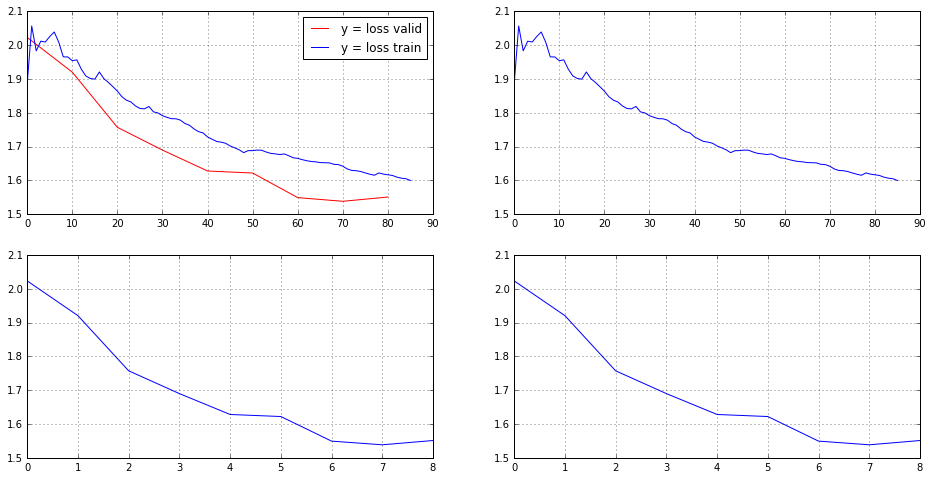

In [ ]:
training_c.training(dataDir)

In [ ]:
save_net(net['last'], 'new_cnn2_1.net', dataDir)